In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import datetime as dt
import numpy as np

from scipy import stats
from sklearn import cluster
import scipy.cluster.hierarchy as sch

sns.set(rc={'figure.figsize':(14, 8)})


from IPython.display import display

Т.к данные весят не так уж и много, то для удобства читаем их в датафремы, переводим время в datetime для дальнейшей работы, удаляем "битые" наблюдения

In [2]:
df_dle_users= pd.read_csv('data/copy_dle_users.csv')
df_dle_users.reg_date = pd.to_datetime(df_dle_users.reg_date, unit='s')
df_dle_users = df_dle_users.query('reg_date > 1970')\
                                               .rename(columns={'name' : 'login'})

df_characters = pd.read_csv('data/copy_ms_characters.csv')
df_characters.created_at = pd.to_datetime(df_characters.created_at)
df_characters = df_characters.query('created_at.dt.year > 1970')

Посчитаем кол-во персонажей на каждом аккаунте

In [3]:
df_char_per_acc = df_characters.groupby('login', as_index=False)[['username']].nunique()
quantile90 = df_char_per_acc.username.quantile(0.9)

Так как на 90% аккаунтов находится {{quantile90}} или меньше персонажей, то логично отфильтровать выборку по этому значению, чтобы избежать влияния выбросов в дальнейшем 

In [4]:
df_char_per_acc  = df_char_per_acc .query('username <= 3')

Соберем таблицу логин + персонажи на аккаунте +дата регистрации, основываясь на отфильтрованных данных. Плюс соберем воедино старые и новые записи

In [5]:
df_characters = df_characters.query('login in @df_char_per_acc.login')
df_lur = pd.merge(df_dle_users, df_characters, how='inner', on='login')

Для начала разобьем игроков на когорты.
Допустим, по времени регистрации. Так как время регистрации у нас начинается с 2015 года, то сначала выберем годовой промежуток

In [6]:
df_lur['year'] = df_dle_users.reg_date.dt.year
df_cohort_uniq = df_lur.groupby('year', as_index=False)[['login', 'username']].nunique()
melted_df = df_cohort_uniq[['year', 'login', 'username']].melt(id_vars=['year'], value_vars=['login', 'username'])
df_cohort_uniq

,year,login,username
0,2015.0,1448,2067
1,2016.0,5159,7740
2,2017.0,6120,9655
3,2018.0,8140,12879
4,2019.0,12250,18811
5,2020.0,18997,25668
6,2021.0,83954,105912
7,2022.0,38914,46882


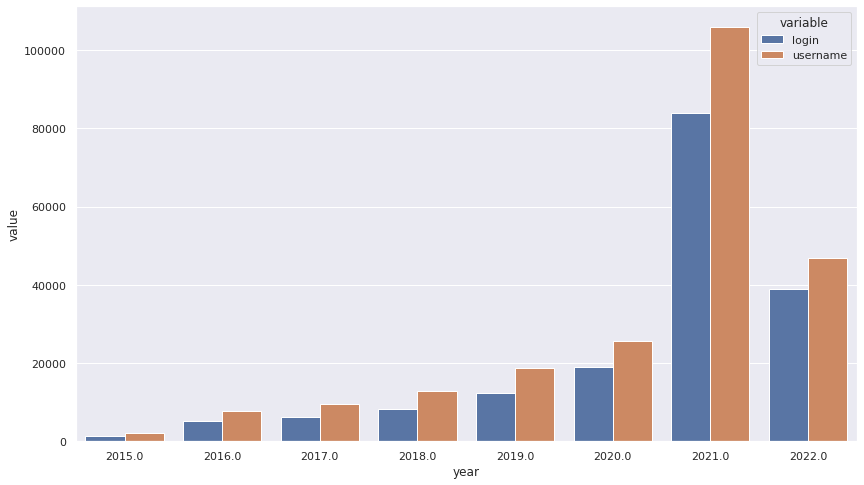

In [7]:
ax = sns.barplot(x='year', y='value', data=melted_df , hue='variable')

Как видим, число уникальных аккаунтов, а вместе с тем и количество новых персонажей только росло от года к году, 22 год только начался, а число желающих жить на пустошах уже достигло почти половины от прошлогоднего показателя. 


#Продолжительность сессий <br>
Добавим в таблицу с данными о времени начала и конца сессии данные о создании аккаунта и посчитаем разницу между началом и концом сессии, сгруппируем по году создания персонажа и рассчитаем среднее значение timedelta в секундах.

In [8]:
df_session_duration = pd.read_csv('data/copy_mc_session_durations1.csv')
df_session_duration1 =pd.read_csv('data/copy_mc_session_durations2.csv')

df_session_duration_u = pd.concat([df_session_duration, df_session_duration1])
df_session_duration_u.session_start = pd.to_datetime(df_session_duration_u.session_start)
df_session_duration_u.session_end = pd.to_datetime(df_session_duration_u.session_end)
del df_session_duration, df_session_duration1

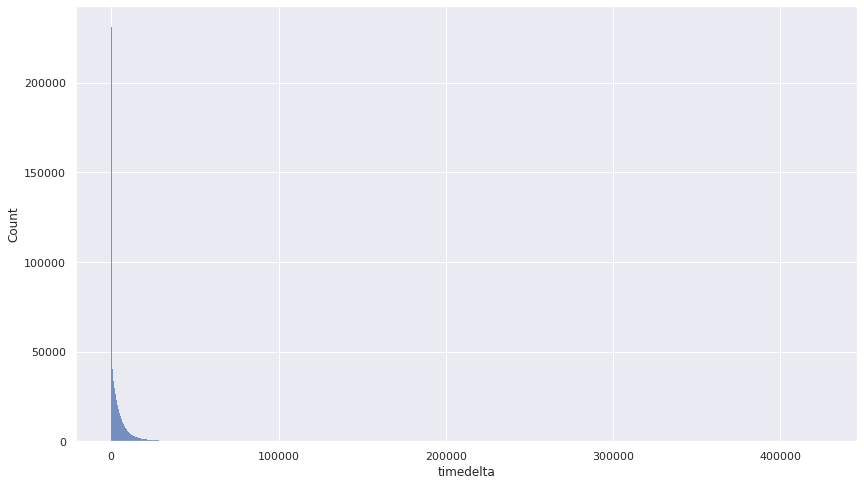

In [9]:
df_duration_reg_year = pd.merge(df_session_duration_u, df_lur[['username', 'created_at', 'reg_date']], on='username')
df_duration_reg_year['year_created'] = df_duration_reg_year.created_at.dt.year 
df_duration_reg_year['year_reg'] = df_duration_reg_year.reg_date.dt.year 
df_duration_reg_year['timedelta'] = (df_duration_reg_year['session_end'] - df_duration_reg_year['session_start']).dt.total_seconds()

# пока нам не нужны исходные таблицы, мы их удалим, чтобы не забивали оперативку
del df_session_duration_u

sns.histplot(data=df_duration_reg_year, x='timedelta',binwidth=60)
plt.show()

И так, мы наблюдаем сильную ассиметрию в распределении, т.о. понятие среднего к этой выборке неприменимо. Первым делом удалим все нулевые сессии и оставим все, что больше одной минуты. 

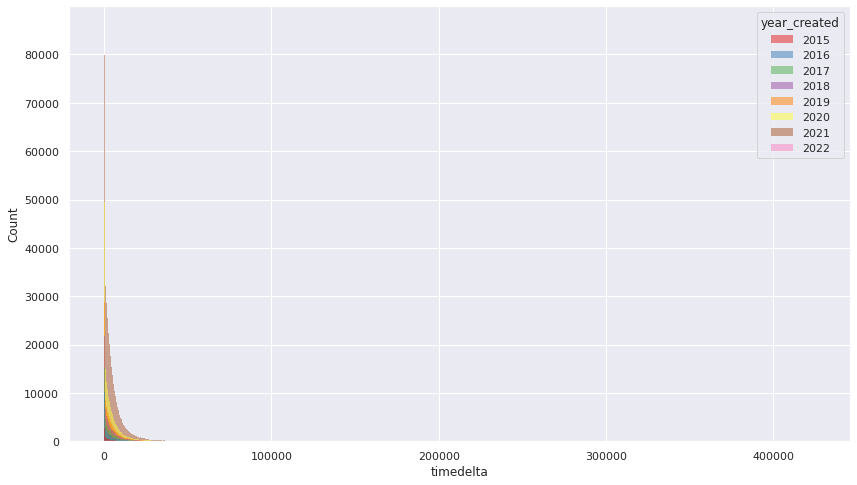

In [10]:
df_duration_reg_year= df_duration_reg_year.query('timedelta >= 60')
sns.histplot(data=df_duration_reg_year, 
                     x='timedelta',
                     binwidth=120, 
                     hue='year_created',
                     palette='Set1',
                     edgecolor='none')
plt.show()

Отлично. Ничего не поменялось :D Рассчитаем 0,05 квантиль, медиану и межквантильный интервал для игроков разных лет регистрации

In [11]:
# вариант, если надо сделать много кастомных агрегирующих функций
def interquan(x,l=0.25,h=0.75):
    qrange=x.quantile([l, h])
    return(f'{qrange[l]:.0f} - {qrange[h]:.0f}')

df_quant = df_duration_reg_year.groupby('year_created', as_index=False)[['timedelta', 'username']]\
                                                        .agg(quantile005=('timedelta',lambda x:np.quantile(x,0.05)),
                                                                char_count=('username','count'),
                                                                timedelta_med = ('timedelta', 'median'),
                                                                inter_timedelta = ('timedelta', lambda x:interquan(x)),
                                                                max_session_dur = ('timedelta', 'max'))

#я хотел вывести таблички в markdown, но у меня почему-то не подтягиваются переменные в ячейку markdown
# простой вариант с describe, но мне захотелось так
# df_duration_reg_year.groupby('year_created')['timedelta'].describe(percentiles = [0.05, 0.25, 0.5, 0.75]).drop(['mean', 'std'], axis=1)
df_quant

,year_created,quantile005,char_count,timedelta_med,inter_timedelta,max_session_dur
0,2015,155.0,38839,2662.0,677 - 6734,367758.0
1,2016,153.0,137244,2625.0,637 - 6489,303319.0
2,2017,163.0,222314,2905.0,815 - 6898,286143.0
3,2018,161.0,329486,2875.0,817 - 6815,373644.0
4,2019,162.0,441506,2869.0,828 - 6761,424489.0
5,2020,163.0,756633,2862.0,849 - 6618,294666.0
6,2021,179.0,1699345,3256.0,1185 - 6947,341116.0
7,2022,214.0,436767,3709.0,1479 - 7584,299780.0


Из приведенной таблички видно, что 5% сессий длится от  2,5 до 3,5 минут в зависимости от года регистрации, причем чем старше пресонаж, тем меньше количество таких сессий у этого персонажа. Как мне подсказали, это связано с посещением внутриигрового аукциона. Количество сессий в зависмости от года регистрации (char_count) растет от года к году, что отлично бьется с первой диаграммой, показывающей количество зарегистрированных пользователей. Так же среднее время (в нашем случае медиана) провождения в игре у новых игроков выше почти на  20 минут  (61 минута у игроков, зарегестрированных в 2022 году против 44 минут у игроков с 2015 года). В большинстве случаев игроки разных лет проводят в игре от 10-25 минут до 2 часов, причем тут тоже сохраняется тенденция: чем новее игрок, тем больше времени он проводит в игре. Если рассмотреть максимальные продолжительности сессий, то строгой закономерности выявить не удается, стоить отметить, что эти сессии длятся по 90+ часов. Вероятно, это могут быть игроки, которые просто не завершают активную сессию после того, как отходят от пк (afk players), либо боты, либо трейдеры. К сожалению, из-за незнания внутренних механик игры точнее сказать не могу.

##Рассмотрим параметр open rating influence <br>
Он находится в табличке session_duration_u (объединенные старые и новые данные). Совеместим данные о продолжительности сессий с данными о силе и влиянии игрока

In [12]:
df_sliding_power = pd.read_csv('data/copy_mc_player_sliding_power.csv')
df_sliding_power1 = pd.read_csv('data/copy_mc_player_sliding_power1.csv')

df_sliding_u = pd.concat([df_sliding_power, df_sliding_power1])
df_sliding_u.date = pd.to_datetime(df_sliding_u.date)

del df_sliding_power, df_sliding_power1

In [13]:
df_sd_ori = pd.merge(df_duration_reg_year[['username', 'year_created', 'timedelta', 'year_reg']],
                                     df_sliding_u.drop(['current_gear_power', 'id'], axis=1),
                                     how='inner',
                                     on='username')

Для начала вообще посмотрим, как распределяются игроки по своему влиянию и времени, проведенному в игре на момент последнего наблюдения.

In [14]:
# датафрем для того, чтобы посмотреть, сколько было наиграно секунд игроком на момент последней записи лога
df_sd_ori_last = df_sd_ori.sort_values('date')[['username', 'date', 'play_time_seconds']]\
                                            .groupby('username', as_index=False).last()
print(f"{df_sd_ori_last['username'].nunique()} уникальных персонажей на данный момент")

131326 уникальных персонажей на данный момент


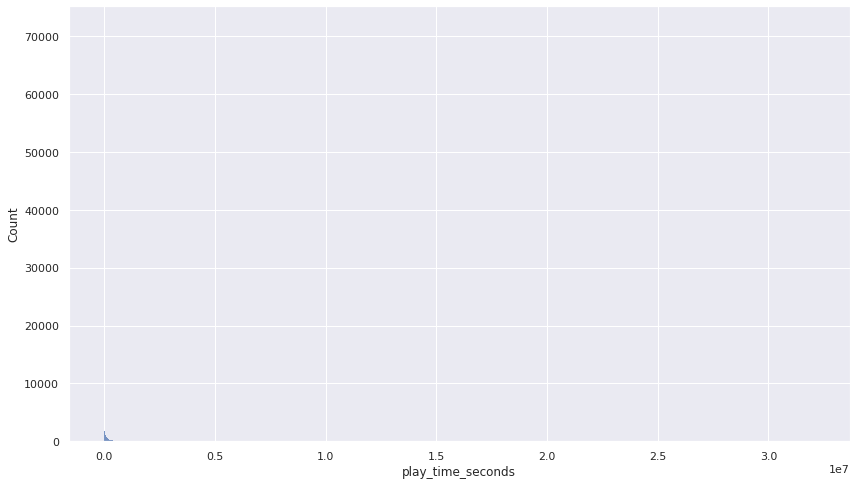

In [15]:
sns.histplot(data=df_sd_ori_last, 
                     x = 'play_time_seconds', 
                     edgecolor='none')
plt.show()

Вероятно, у нас битые логи, присмотримся к данным внимательнее. кажется, нулевые значения нам не подходят. 
В данной ситуации нас интересуют активные игроки и игроки, которые провели в игре хотя бы час (походили, что-то посмотрели и дропнули). 

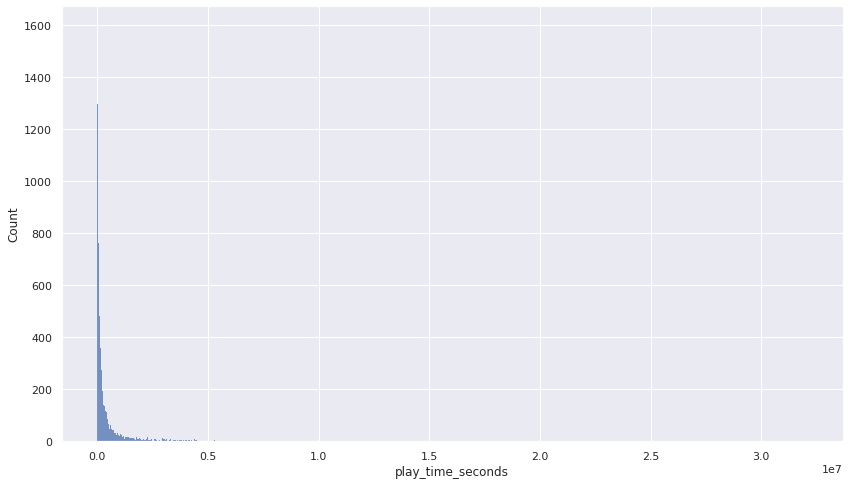

In [16]:
df_sd_ori_last = df_sd_ori_last.query('play_time_seconds >= 60*60')
sns.histplot(data=df_sd_ori_last, 
                     x=df_sd_ori_last.play_time_seconds, 
                     binwidth=3600,
                     edgecolor='none')
plt.show()

In [17]:
print(df_sd_ori_last['play_time_seconds'].describe().drop(['mean', 'std']))
df_sd_ori= pd.merge(df_sd_ori_last['username'], df_sd_ori, on = 'username', how='left')
# отлично, выбросили ненужные данные, теперь разберемся с агрессивностью игроков

count       60251.0
min          3600.0
25%         52598.0
50%        151781.0
75%        483310.0
max      32080380.0
Name: play_time_seconds, dtype: float64


In [18]:
# агреггируем наши данные, посчитаем медиану длинны сессии для каждого игрока, значение силы и агрессии на момент записи последнего лога.
df_sd_ori = df_sd_ori.sort_values('date')\
                                    .groupby('username', as_index=False)\
                                    .agg({ 'date':'last',
                                              'year_created':'last',
                                              'year_reg':'last',
                                              'timedelta':'median',
                                              'play_time_seconds':'last',
                                              'sliding_power':'last',
                                              'openworld_rating_influence':'last'})

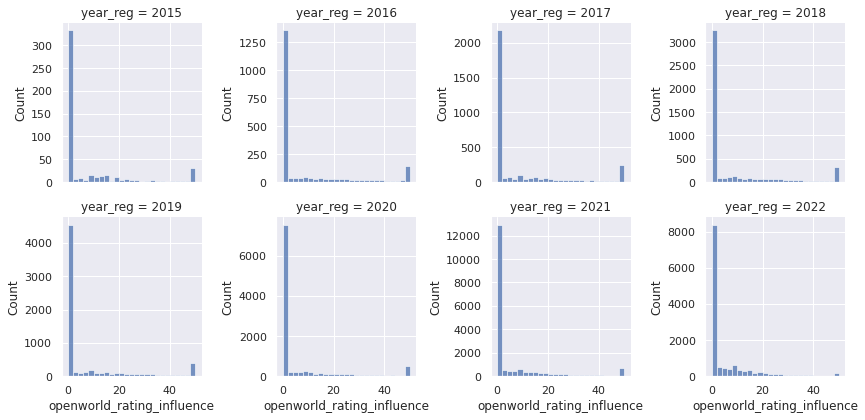

In [19]:
#sns.FacetGrid(data=df_sd_ori_last, x='sliding_power', binwidth=100, hue='year_created', multiple='dodge', palette='Set1', kde=True)
fg = sns.FacetGrid(df_sd_ori,
                               col='year_reg', 
                               col_wrap=4, 
                               sharey=False)
fg.map(sns.histplot, 'openworld_rating_influence', binwidth=2)
plt.show()

Как видно из гистограмм поведение игроков в зависимости от года в основном не меняется (что также говорит о плохом выборе признака для разделения на когорты в данном случае). Отсюда видно, что большая масса игроков все же склонна к мирному существованию - 75% из общей выбоки имеют рейтинг ниже 8.1. Остальные же пк-шат пока не упираются в верхнюю планку, либо пока их не начнут сливать другие игроки. <br>
Самым очевидным на первый взгляд будет сопоставить силу/время,проведенное в игре и рейтинг

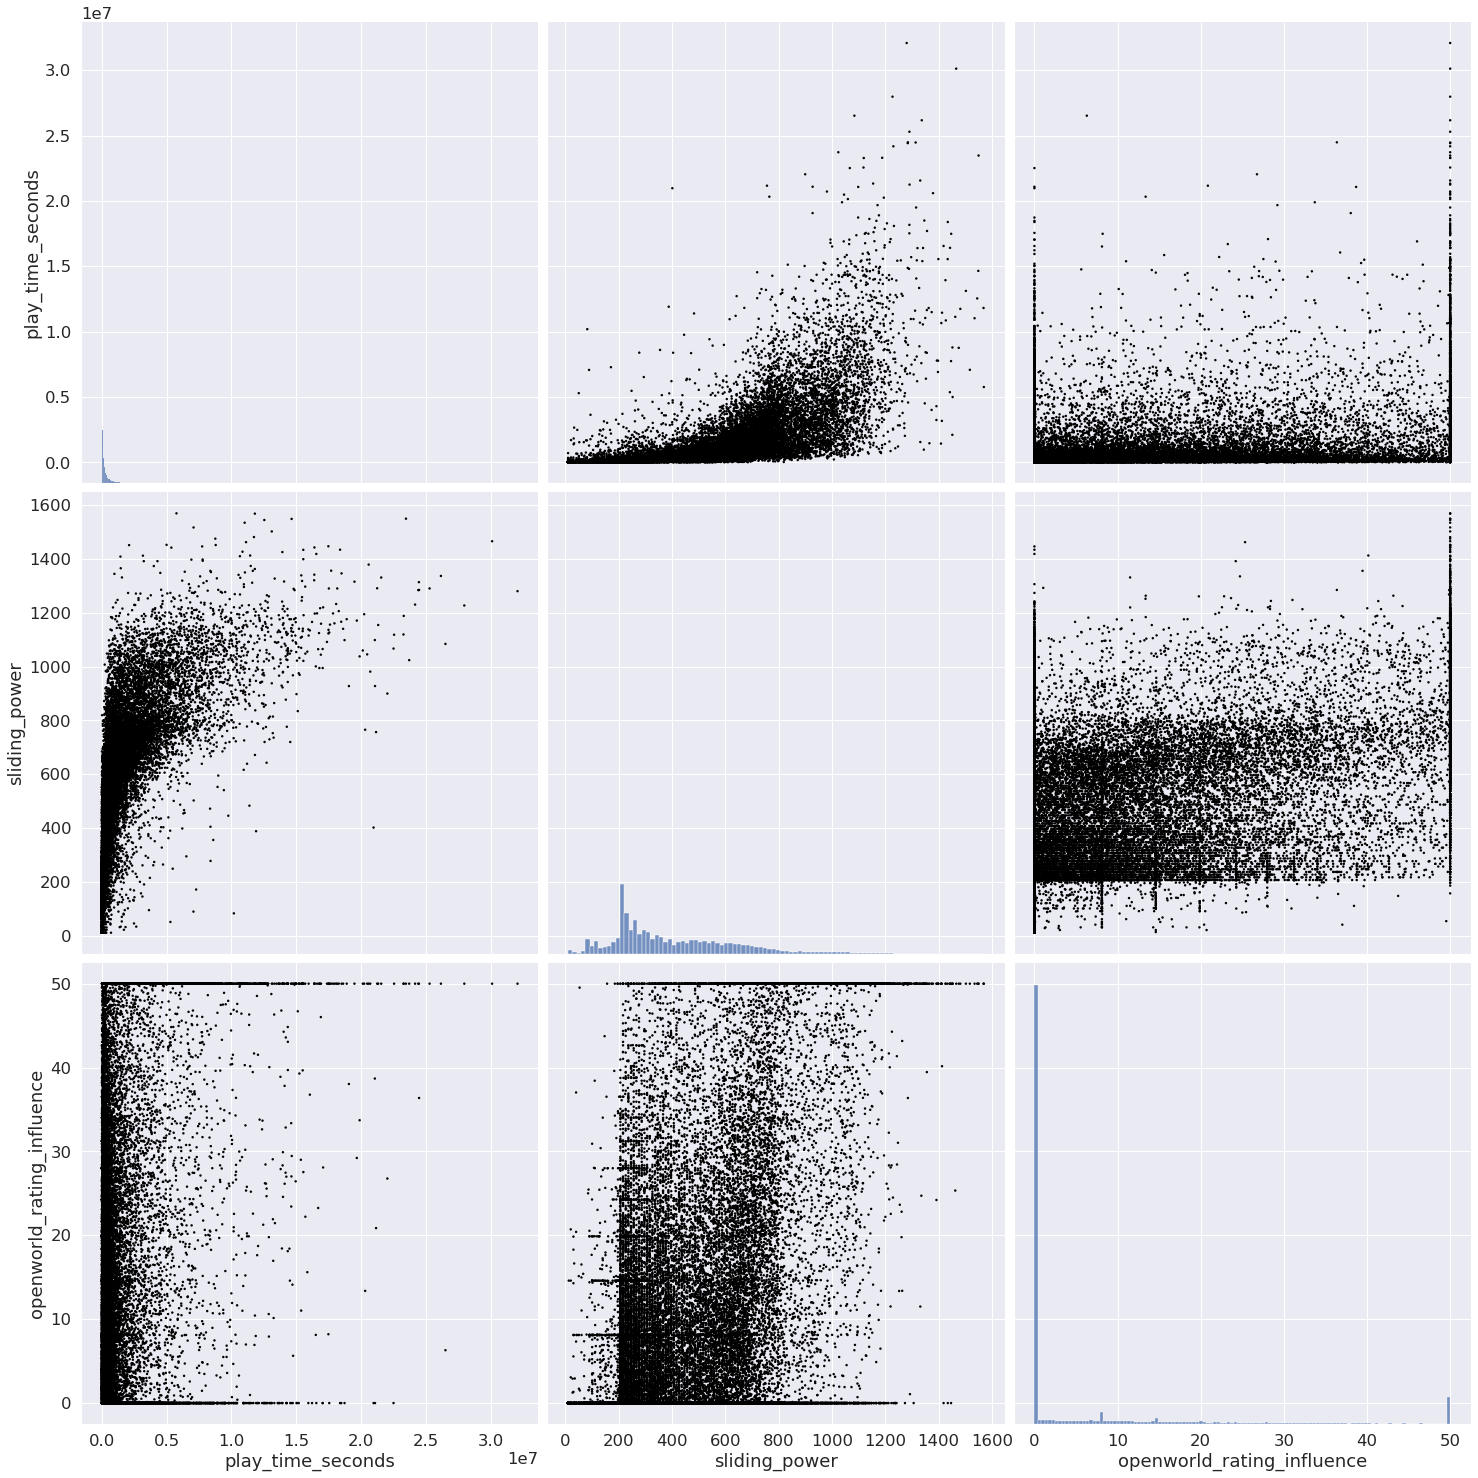

,play_time_seconds,sliding_power,openworld_rating_influence
count,60251.0,60251.000,60251.00000
min,3600.0,10.450,0.00000
25%,52598.0,226.538,0.00000
50%,151781.0,332.753,0.00000
75%,483310.0,545.284,8.11555
max,32080380.0,1569.870,50.00000


In [20]:
sns.set(font_scale=1.5)
pf = sns.pairplot(df_sd_ori[['play_time_seconds', 'sliding_power', 'openworld_rating_influence']], 
                             height=7,
                             plot_kws={'edgecolor':'none', 's':6, 'facecolor':'black'})
plt.show()
df_sd_ori[['play_time_seconds', 'sliding_power', 'openworld_rating_influence']].describe().drop(['mean', 'std'])

Из данных графиков можно выделить несколько поинтов, которые надо рассмотреть в дальнейшем. Во-первых, персонажи стартуют не с нулевой силой, она равна ~ 200, что объясняет, почему только созданные персонажи могут пк-шить и имеют рейтинг 50 при очень малом времени игры (сразу возникает вопрос, есть ли связь между временем создания аккаунта и такого поведения в игре *я посмотрел - нет, все также). Во-вторых, в системе учета рейтинга есть пороги, которые игрок должен преодолеть, чтобы его повысило на следующий уровень агресии. Первый порог находится в районе 8, что соответствует 75% процентилю, т.е. большинство игроков не переходит его. Из очевидного, если посмотреть на график время в игре/сила, то видно, что чем больше игрок проводит в игре, тем сильнее он становится.

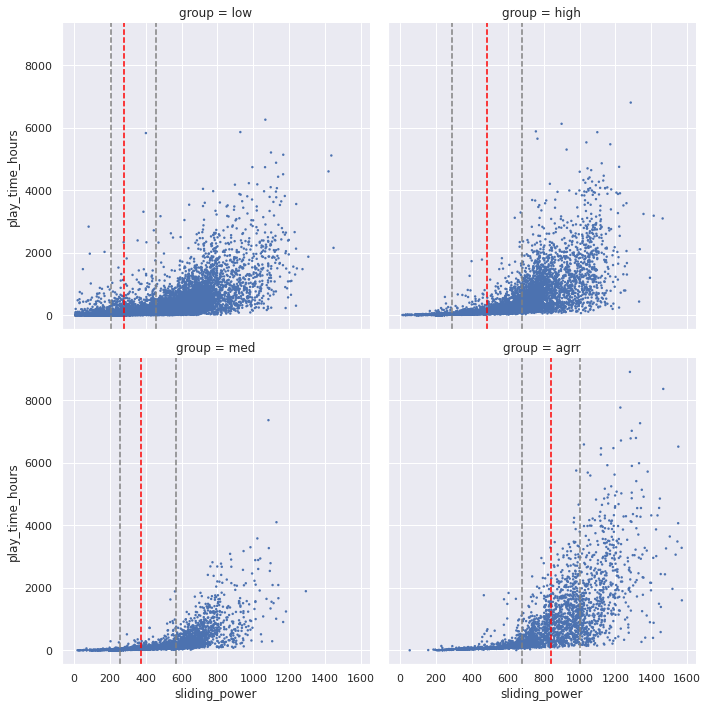

play_time_hours                                                 \
                count        mean          std       min         25%   
group                                                                  
agrr           2513.0  984.515914  1139.305488  3.653889  179.240278   
high          12705.0  283.577126   536.866256  1.341944   28.254444   
low           38933.0  112.690345   292.453831  1.000000   10.457778   
med            6100.0  155.685689   326.753188  1.690000   21.923819   

                                             
              50%          75%          max  
group                                        
agrr   563.459444  1393.002778  8911.216667  
high    81.366389   269.770556  6801.377222  
low     29.741667    85.159722  6254.074167  
med     52.195833   134.254653  7367.053333

sliding_power                                                       \
              count        mean         std      min       25%       50%   
group                                                                      
agrr         2513.0  831.433352  249.306376  53.5785  677.2250  842.8330   
high        12705.0  504.251799  236.100061  13.0276  286.6770  481.8920   
low         38933.0  336.563045  186.808615  10.4500  206.5260  280.3280   
med          6100.0  421.690350  190.102673  20.4621  256.6015  376.7385   

                            
              75%      max  
group                       
agrr   1000.41000  1569.87  
high    677.26500  1462.70  
low     456.87100  1446.89  
med     566.96825  1292.79

In [21]:
# поппытался грубо разделить на группы по агрессивности и прикинуть отношение затраченного времени на игру и силе.
# первая группа - 0ori, вторая - 75%, третья от 75% до 98%, четвертая все >98%
test = df_sd_ori
test['group'] = np.where(df_sd_ori.openworld_rating_influence ==0, 'low',
                        np.where(df_sd_ori.openworld_rating_influence <= 8.1, 'med',
                        np.where(df_sd_ori.openworld_rating_influence <= 48, 'high', 'agrr')))  
test['play_time_hours'] = test.play_time_seconds/3600

sns.set(font_scale=1)
fg = sns.FacetGrid(data=test, col='group', col_wrap=2, height=5)
fg.map(sns.scatterplot, 'sliding_power',  'play_time_hours', s=6, edgecolor='none')

def specs(x, **kwargs):
    plt.axvline(x.quantile(0.5), c='red', ls='--')
    plt.axvline(x.quantile(0.75), c='grey', ls='--')
    plt.axvline(x.quantile(0.25), c='grey', ls='--')

fg.map(specs, 'sliding_power')    
    
plt.show()

display(test.groupby('group')[['play_time_hours']]\
      .describe())
display(test.groupby('group')[['sliding_power']]\
      .describe())

Как видно из гистограмм между группами есть существенные различия. Группа неагрессивных игроков 'low' самая многочисленная (~39к), при этом среднее время (здесь и далее имеется в виду медиана), проведенное в игре является самым низким около 30 часов, то же самое относится и к силе игроков в этой группе - в среднем она составляет 280 единиц. По мере нарастания агрессивности групп наблюдается рост уровня силы и среднего времени, проведенного в игре. Но больше всего отличается группа с самым высоким ORI, это игроки, которые в среднем провели в игре более 550 часов, для сравнения, в предыдущей группе этот показатель колеблется в районе 80 часов. Также показатель их силы почти в два раза превосходит прошлую группу (843 против 482). в этой же группе находится самый сильный игрок с показателем силы 1569 (тот, что 1647.52 отлетел вместе с твинками).   <br>
Раз мы затронули тему силы, то рассмотрим, как же распределяется сила персонажей, созданных в разные годы

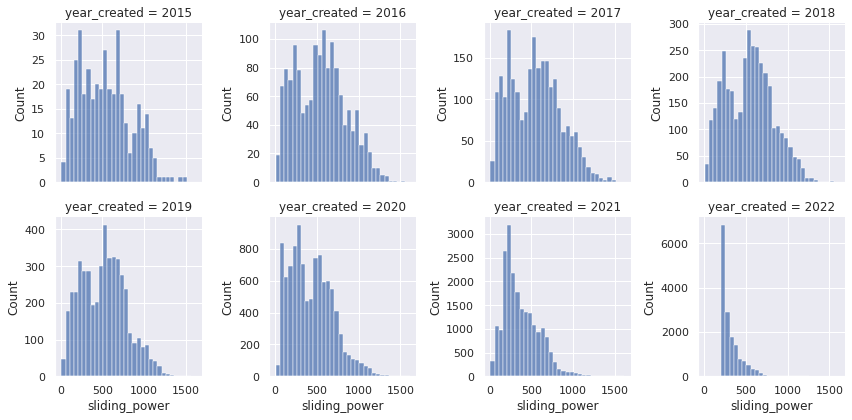

In [22]:
fg = sns.FacetGrid(data=test, col='year_created', col_wrap=4, sharey=False)
fg.map(sns.histplot, 'sliding_power', binwidth=50)
# def specs(x, **kwargs):
#     plt.axvline(x.quantile(0.5), c='red', ls='--')
#     plt.axvline(x.quantile(0.75), c='grey', ls='--')
#     plt.axvline(x.quantile(0.25), c='grey', ls='--')
# fg.map(specs, 'sliding_power')    
plt.show()

Если рассматривать распределение силы без разделения на годы (см. pairplot), то видно только унимодальное распределение, похожее на нормальное с правосторонней ассиметрией, но при разделении ряда на годовые выборки разной длинны, то сразу наблюдается бимодальное распределение по силе во всех случаях, кроме последних двух лет. А так как за последние у нас имеется самое большое количество наблюдений, то в общей ситуации они перетягивают силы к значению ~250. Попробуем разделить выборку на две части: до 2020 года и после 2020. 

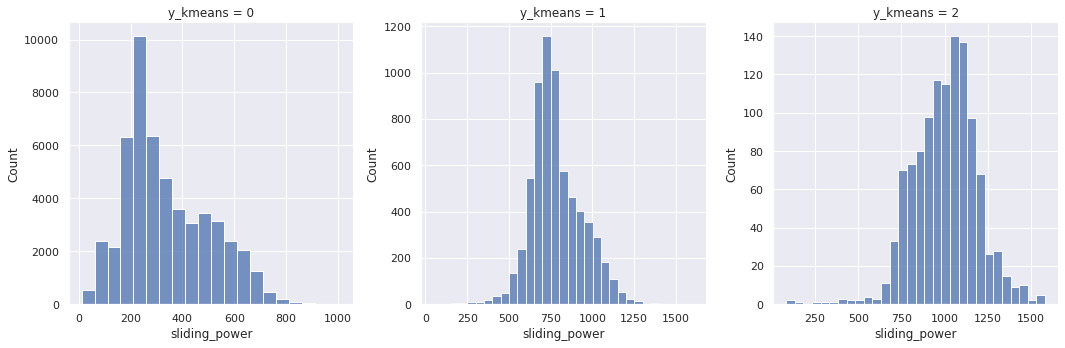

In [23]:
test = df_sd_ori

clust = test[['play_time_hours', 'sliding_power']]
kmeans= cluster.KMeans(n_clusters=3,)
kmeans.fit(clust)
test['y_kmeans'] = kmeans.predict(clust)

fg = sns.FacetGrid(data=test, col='y_kmeans', col_wrap=3, sharey=False, height=5, sharex=False)
fg.map(sns.histplot, 'sliding_power', binwidth=50)
 
plt.show()

In [24]:
#df_faction_logs = pd.read_csv('data/copy_mc_player_faction_logs.csv')
# df_faction_logs.date = pd.to_datetime(df_faction_logs.date)
# df_faction = pd.read_csv('data/copy_mc_player_faction.csv')
# df_faction1 = pd.read_csv('data/copy_mc_player_faction1.csv')
#df_faction_logs

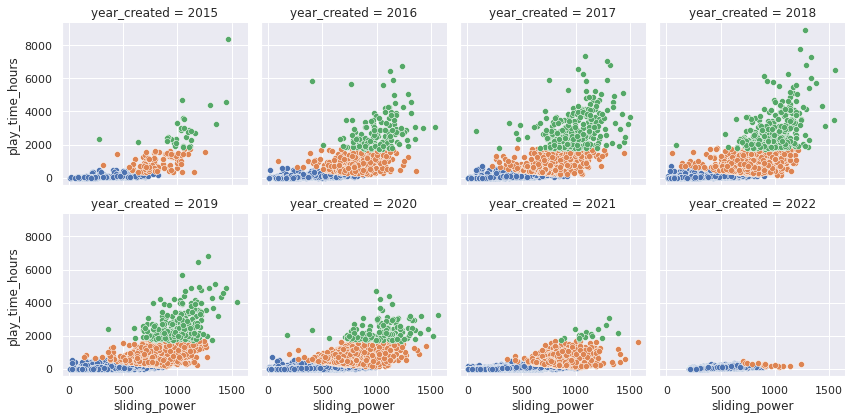

In [25]:
centers = kmeans.cluster_centers_
fg = sns.FacetGrid(data=test, col='year_created', col_wrap=4, sharey=True, hue='y_kmeans')
fg.map(sns.scatterplot, 'sliding_power', 'play_time_hours')

plt.show()